In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import care, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Particle

In [217]:
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 1
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

In [218]:
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)
gamma, omega, ba_force**2, std_detection**2, std_z

(4.550639205542112e-05,
 501266.40589032974,
 5.237976008129461e-41,
 3.538644164320225e-21,
 1.4571158150923128e-14)

In [219]:
period = 2*np.pi/omega
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]

In [220]:
coupling = (1/(4*np.pi))*(ba_force**2)
coupling

4.1682488674527876e-42

In [221]:
env = Particle(omega, gamma, coupling, radius=radius, eta_detection=1, T=293)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
std_detection, variance_process

(11.436084942324618, 537605.4136351169)

In [254]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd=(Ad-np.eye(2))@np.linalg.inv(env.A)@env.B

In [329]:
780/0.03

26000.0

In [330]:
def compute_phonons_per_gain_LQR(Ad, Bd, omega):
    Q = np.array([[omega/2, 0],
                            [0, omega/2]])

    steps = 10000
    g_fbs = omega*np.linspace(0.01, 2, 201)
    z_squared = np.zeros(g_fbs.shape)
    for j, g_fb in enumerate(g_fbs):
        z = np.zeros((steps, 2))
        z[0,0] = 5
        Q2 = np.array([[omega/(g_fb**2)]])
        S, _, L =  dare(Ad, Bd, Q, Q2)
        for i in range(1,steps):
            z[i] = (Ad-Bd@L)@z[i-1]
        z_squared[j] = np.power(z,2).mean(axis=0).sum()
    return z_squared, g_fbs    

In [331]:
z_squared, g_fbs = compute_phonons_per_gain_LQR(Ad, Bd, omega)

(0.0, 2.5)

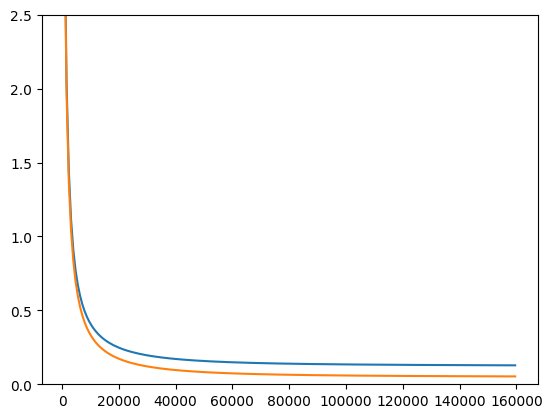

In [332]:
plt.plot(g_fbs/(2*np.pi), -0.5+0.25*(z_squared+0.3+np.trace(corrected_matrix)))
plt.plot(g_fbs/(2*np.pi), -0.5+0.25*(z_squared+np.trace(corrected_matrix)))
plt.ylim([0, 2.5])

In [333]:
df = pd.DataFrame()
df['gains'] = g_fbs
df['theory_lqr'] = -0.5+0.25*(z_squared+np.trace(corrected_matrix))
df.to_csv('../data/theory_lqr.csv')

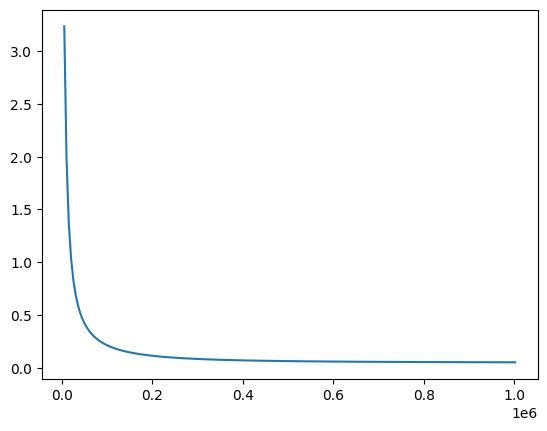

In [334]:
plt.plot(g_fbs, df['theory_lqr'])

In [325]:
df.tail()

,gains,theory_lqr
196,156382.847360,0.106682
197,157176.648672,0.106584
198,157970.449983,0.106488
199,158764.251295,0.106392
200,159558.052607,0.106298


In [249]:
x0 = 100
states = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
time_steps = np.linspace(0, 1e5, int(1e5+1)).astype(int)
z_ss = np.zeros((time_steps.shape[0], 2))
for i, step in tqdm(enumerate(time_steps)):
    z_ss[step, :] = np.matmul(np.linalg.matrix_power(Ad - np.matmul(Bd, G), step),states).reshape(2)

100001it [00:07, 13642.28it/s]


In [250]:
np.matmul(np.linalg.matrix_power(Ad - np.matmul(Bd, G), int(1e5)),states)

array([[0.],
       [0.]])

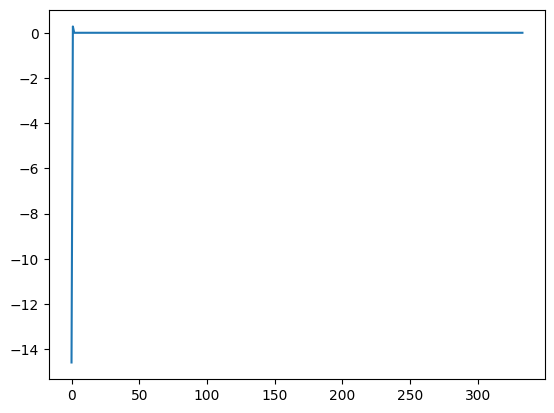

In [251]:
plt.plot(z_ss[:,0][::300])

In [86]:
corrected_matrix = np.eye(2)
corrected_matrix[0,0] = cov_matrix[0,0]/(0.3*eta_detection)
np.power(z_ss[-10:,:].mean(axis=0),2) + corrected_matrix

array([[1.11116180e+01, 1.02018227e-03],
       [5.06907326e-04, 1.00102018e+00]])

In [76]:
cov_matrix = np.eye(2)
cov_matrix[0,0] = cov_matrix[0,0]/(0.3*eta_detection)
cov_matrix

array([[3.33333333, 0.        ],
       [0.        , 1.        ]])